In [1]:
# Carter Brown
# Created: December 23, 2016
# Modifyd: June 6, 2017

In [2]:
# Inspired by WildML
# Attempting to make more modular and abstracted
# See very bottom for examples of different sizes
# Adding more documentation
# Classification problem on two classes

In [3]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%pylab inline
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Some Global Variables
TRAINING_SIZE = 200
TRAINING_NOISE = 0.20
SPACE_DIM = 2
NUM_CLASSES = 2

# Grad Desc parameters (default vals chosen by WildML)
EPSILON = 0.01 # learning rate
REG_LAMBDA = 0.01 # regularization strength

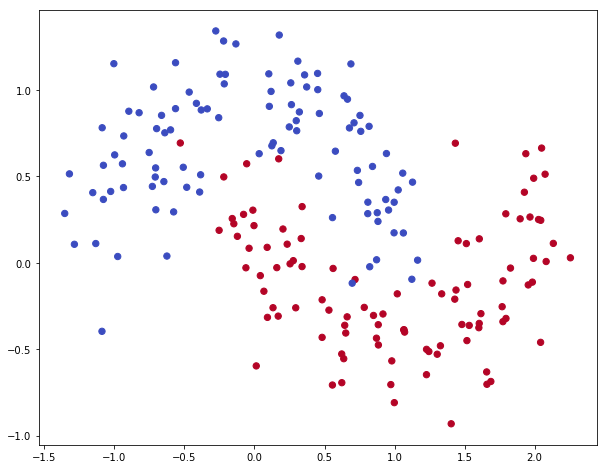

In [5]:
# Generate a dataset and plot it
np.random.seed(0) # to be consistently random
X, y = sklearn.datasets.make_moons(TRAINING_SIZE, noise=TRAINING_NOISE)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.coolwarm)

In [6]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [7]:
def plot_decision_boundary(pred_func):
    """ @param pred_func is a prediction fct (i.e. logistic regression
            predictor, neural net, etc.)
        Effect: Plots decision bndry of prediction fct
            Colors plot space based on decision boundary
            from WildML """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate grid of pts with dist h between
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

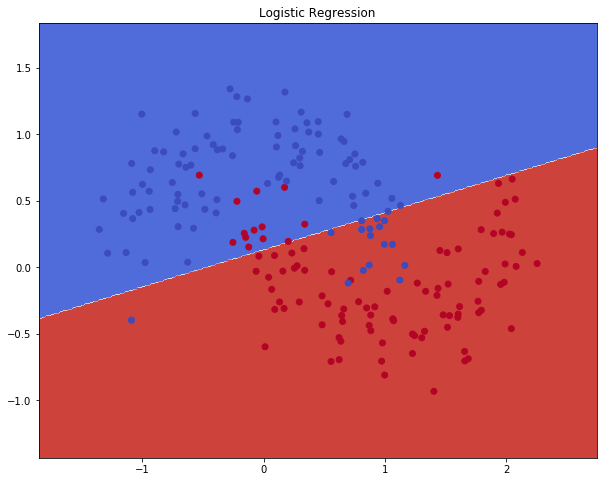

In [8]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

In [9]:
def inst_model(hidden_layers):
    """ @param hidden_layers is an array containing the sizes of subsequent
            hidden layers
        Returns: basic neural network model with random weights
        Precondition: each element of hidden_layers is positive integer"""
    np.random.seed(0)
    num_hidds = hidden_layers.shape[0]
    Wlst = []
    blst = []
    if (num_hidds==0): # case where don't pass anything
        Wlst += [np.random.randn(SPACE_DIM,NUM_CLASSES) / np.sqrt(SPACE_DIM)]
        blst += [np.zeros((1,NUM_CLASSES))]
        print("no hidden layer dimensions passed...\ninstantiating random weights")
        return {'Wlist':Wlst,'blist':blst}
    else:
        inc_dim=0
        out_dim=0
        for layer in arange(num_hidds):
            print("instantiating random weights...")
            if (layer == 0):
                inc_dim = SPACE_DIM
            else:
                inc_dim = hidden_layers[layer-1]
            out_dim = hidden_layers[layer]
            Wlst += [np.random.randn(inc_dim,out_dim) / np.sqrt(inc_dim)]
            blst += [np.zeros((1,out_dim))]
        Wlst += [np.random.randn(out_dim,NUM_CLASSES) / np.sqrt(out_dim)] # cuz inc_dim is now just the last out_dim
        blst += [np.zeros((1,NUM_CLASSES))]
        return {'Wlist':Wlst,'blist':blst}

In [10]:
def for_prop(model, X):
    """ model is the NN model and X is the data
        Returns: array with first element a1 actvation layer (tanh) and second
            element the output layer (probs)"""
    Wlst, blst = model['Wlist'], model['blist']
    num_layers = len(Wlst) # note not hidden layers, counts output layer
    activations = [] # to be filled with the activations and exp_scores
    #print("Performing forward prop...")
#    if (num_layers == 1):
#        z = X.dot(Wlst[0]) + blst[0]
#        exp_scores = np.exp(z)
#        return [exp_scores / np.sum(exp_scores, axis=1, keepdims=True)]
#    else:
    for layer in arange(num_layers):
        if (layer == 0):
            z = X.dot(Wlst[0]) + blst[0]
        else:
            z = a.dot(Wlst[layer]) + blst[layer]
        if (layer+1 == num_layers):
            exp_scores = np.exp(z)
            activations += [exp_scores / np.sum(exp_scores, axis=1, keepdims=True)]
        else:
            a = np.tanh(z)
            activations += [a]
    return activations
        
#    z1 = x.dot(W1) + b1
#    a1 = np.tanh(z1)
#    z2 = a1.dot(W2) + b2
#    exp_scores = np.exp(z2)
#    return [a1,(exp_scores / np.sum(exp_scores, axis=1, keepdims=True))]

In [11]:
def calculate_loss(model,X):
    """Note: Performs a forward prop to calculate the loss!"""
    Wlist, blist = model['Wlist'], model['blist']
    activations = for_prop(model,X)
    act_size = len(activations)
    #print("calculating loss...")
    correct_logprobs = -np.log(activations[act_size-1][range(TRAINING_SIZE),y])
    data_loss = np.sum(correct_logprobs)
    # Add regularization term
    sum_sqrs = 0
    #print("regularizing loss...")
    for W in Wlist:
        sum_sqrs += np.sum(np.square(W))
    data_loss += REG_LAMBDA/2 * sum_sqrs
    return 1./TRAINING_SIZE * data_loss

In [12]:
def predict(model, X):
    """Note: performs a forward prop!"""
    activations = for_prop(model, X)
    act_size = len(activations)
    print("predicting...")
    return np.argmax(activations[act_size-1], axis=1)

In [13]:
def backprop(model, activations):
    """Note: activations is the activations list from the forward prop pass"""
    Wlist, blist = model['Wlist'], model['blist']
    act_size = len(activations)
    delta = activations[act_size-1]
    delta[range(TRAINING_SIZE),y] -= 1 # delta at the output of neural net
    dW = 0
    db = 0
    
    for layer in arange(act_size)[::-1]: # go back through other layers
        if (layer == 0):
            dW = np.dot(X.T, delta)
            db = np.sum(delta, axis=0)
            # regularization
            dW += REG_LAMBDA * Wlist[layer]
            #param update
            Wlist[layer] += -EPSILON * dW
            blist[layer] += -EPSILON * db
        else:
            dW = (activations[layer-1].T).dot(delta)
            db = np.sum(delta, axis=0, keepdims=True)
            delta = delta.dot(Wlist[layer].T) * (1 - np.power(activations[layer-1],2))
            #regularization
            dW += REG_LAMBDA * Wlist[layer]
            #param update
            Wlist[layer] += -EPSILON * dW
            blist[layer] += -EPSILON * db

    return {'Wlist': Wlist, 'blist': blist}

In [14]:
emptyarr = arange(0)
empty_model = inst_model(emptyarr)
calculate_loss(empty_model,X)

no hidden layer dimensions passed...
instantiating random weights


1.2674370859163764

In [15]:
predict(empty_model,X)

predicting...


array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int64)

In [16]:
empty_model

{'Wlist': [array([[ 1.24737338,  0.28295388],
         [ 0.69207227,  1.58455078]])], 'blist': [array([[ 0.,  0.]])]}

In [17]:
backprop(empty_model, for_prop(empty_model, X))

{'Wlist': [array([[ 0.29344168,  1.23673254],
         [ 1.24507149,  1.03132389]])],
 'blist': [array([[-0.08998756,  0.08998756]])]}

In [18]:
calculate_loss(empty_model,X)

0.5445175203237651

In [19]:
anotherarr=arange(5)
anotherarr+np.ones(5)
anotherarr

array([0, 1, 2, 3, 4])

In [20]:
model2 = inst_model(anotherarr)
calculate_loss(model2, X)

instantiating random weights...
instantiating random weights...
instantiating random weights...
instantiating random weights...
instantiating random weights...


0.69352065881232694

In [21]:
predict(model2, X)

predicting...


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [22]:
backprop(model2, for_prop(model2, X))

{'Wlist': [array([], shape=(2, 0), dtype=float64),
  array([], shape=(0, 1), dtype=float64),
  array([[ 1.76387594,  0.40011719]]),
  array([[ 0.69200306,  1.58439232,  1.32043086],
         [-0.69097071,  0.67174678, -0.10701501]]),
  array([[-0.05958747,  0.23703545,  0.08315528,  0.83954124],
         [ 0.4393414 ,  0.07024208,  0.25623893,  0.1926277 ],
         [ 0.86252069, -0.11843633,  0.18073165, -0.49306309]]),
  array([[-1.27636726,  0.32677662],
         [ 0.43217488, -0.3710454 ],
         [ 1.13476382, -0.72711012],
         [ 0.02287697, -0.09358257]])],
 'blist': [array([], shape=(1, 0), dtype=float64),
  array([[ -2.66453526e-17]]),
  array([[ -2.22044605e-18,   1.66533454e-18]]),
  array([[  0.00000000e+00,  -8.32667268e-19,   0.00000000e+00]]),
  array([[ -4.44089210e-18,  -1.11022302e-18,   4.44089210e-18,
            4.16333634e-19]]),
  array([[ 0.,  0.]])]}

In [23]:
nparr1=np.arange(4)
nparr2=np.arange(3)
array=[nparr1,nparr2]
array

[array([0, 1, 2, 3]), array([0, 1, 2])]

In [24]:
nparr3=np.arange(6)
array+=[nparr3]
array

[array([0, 1, 2, 3]), array([0, 1, 2]), array([0, 1, 2, 3, 4, 5])]

In [25]:
model3 = inst_model(np.array([3]))
model3

instantiating random weights...


{'Wlist': [array([[ 1.24737338,  0.28295388,  0.69207227],
         [ 1.58455078,  1.32056292, -0.69103982]]),
  array([[ 0.5485338 , -0.08738612],
         [-0.05959343,  0.23705916],
         [ 0.08316359,  0.8396252 ]])],
 'blist': [array([[ 0.,  0.,  0.]]), array([[ 0.,  0.]])]}

In [26]:
backprop(model3, for_prop(model3, X))

{'Wlist': [array([[ 1.11827627,  0.39498982,  0.77305539],
         [ 1.66462067,  1.27441456, -0.81055589]]),
  array([[ 0.48086185, -0.01976028],
         [ 0.11685916,  0.06058881],
         [-0.28286752,  1.20556404]])],
 'blist': [array([[-0.06516027,  0.04893171, -0.00152486]]),
  array([[-0.07909067,  0.07909067]])]}

In [27]:
predict(model3, X)

predicting...


array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

In [28]:
calculate_loss(model3, X)

0.43238663152549239

In [29]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(hidden_layers, num_passes=20000, print_loss=False):
    """ @param hidden_layers: numpy array containing the dimensions of all hidden layers
            N.B. that an empty array means no hidden layers
        @param num_passes: number of passes thru training data for gradient descent
        @param print_loss: If True, prints loss every 1000 iterations
        Effect: builds a neural net model based on architecture given in hidden_layers and by
            global variables for SPACE_DIM and NUM_CLASSES
            Then, it performs backprop for num_passes"""

    # This is what we return at the end
    model = inst_model(hidden_layers)
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):        
        model = backprop(model,for_prop(model, X))
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and (i+1) % 1000 == 0:
            print("Loss after iteration ", i+1, ": ",  calculate_loss(model, X))
            
    return model

instantiating random weights...
Loss after iteration  1000 :  0.0689481948353
Loss after iteration  2000 :  0.0689240522206
Loss after iteration  3000 :  0.0712177023736
Loss after iteration  4000 :  0.0712531147402
Loss after iteration  5000 :  0.0712778521247
Loss after iteration  6000 :  0.0712932876619
Loss after iteration  7000 :  0.0713026613462
Loss after iteration  8000 :  0.0713082934109
Loss after iteration  9000 :  0.0713116451112
Loss after iteration  10000 :  0.0713136130537
Loss after iteration  11000 :  0.0713147451003
Loss after iteration  12000 :  0.0713153758292
Loss after iteration  13000 :  0.0713157092112
Loss after iteration  14000 :  0.0713158690982
Loss after iteration  15000 :  0.0713159302056
Loss after iteration  16000 :  0.0713159371821
Loss after iteration  17000 :  0.0713159163557
Loss after iteration  18000 :  0.0713158829567
Loss after iteration  19000 :  0.0713158455466
Loss after iteration  20000 :  0.071315808723
predicting...


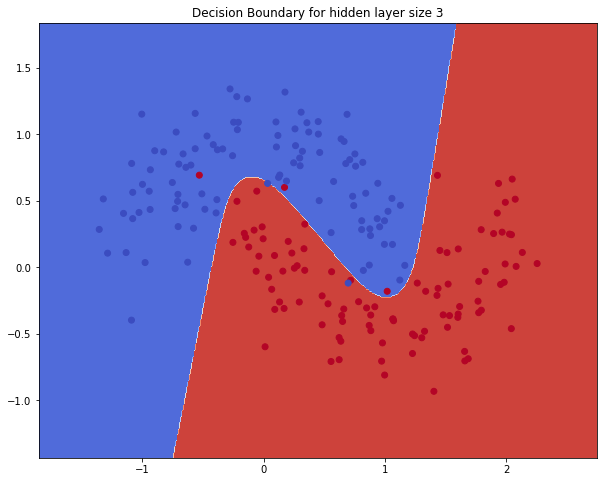

In [30]:
# Build a model with a 3-dimensional hidden layer
model = build_model(np.array([3]), print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

no hidden layer dimensions passed...
instantiating random weights
Loss after iteration  1000 :  0.299722409185
Loss after iteration  2000 :  0.299708448971
Loss after iteration  3000 :  0.29969701943
Loss after iteration  4000 :  0.299687661806
Loss after iteration  5000 :  0.299680000508
Loss after iteration  6000 :  0.299673728031
Loss after iteration  7000 :  0.299668592612
Loss after iteration  8000 :  0.299664388129
Loss after iteration  9000 :  0.299660945823
Loss after iteration  10000 :  0.29965812753
Loss after iteration  11000 :  0.29965582013
Loss after iteration  12000 :  0.29965393101
Loss after iteration  13000 :  0.299652384344
Loss after iteration  14000 :  0.299651118054
Loss after iteration  15000 :  0.299650081314
Loss after iteration  16000 :  0.299649232511
Loss after iteration  17000 :  0.299648537578
Loss after iteration  18000 :  0.29964796862
Loss after iteration  19000 :  0.299647502801
Loss after iteration  20000 :  0.299647121424
predicting...


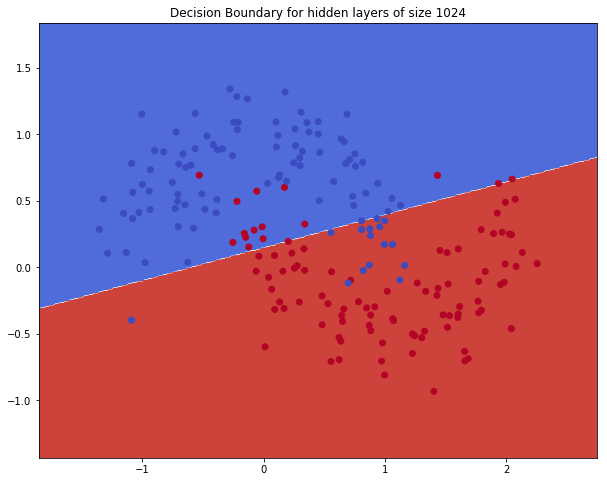

In [31]:
model = build_model(np.array([]), print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of size 1024")

instantiating random weights...
predicting...
instantiating random weights...
predicting...
instantiating random weights...
predicting...
instantiating random weights...
predicting...
instantiating random weights...
predicting...
instantiating random weights...
predicting...
instantiating random weights...
predicting...


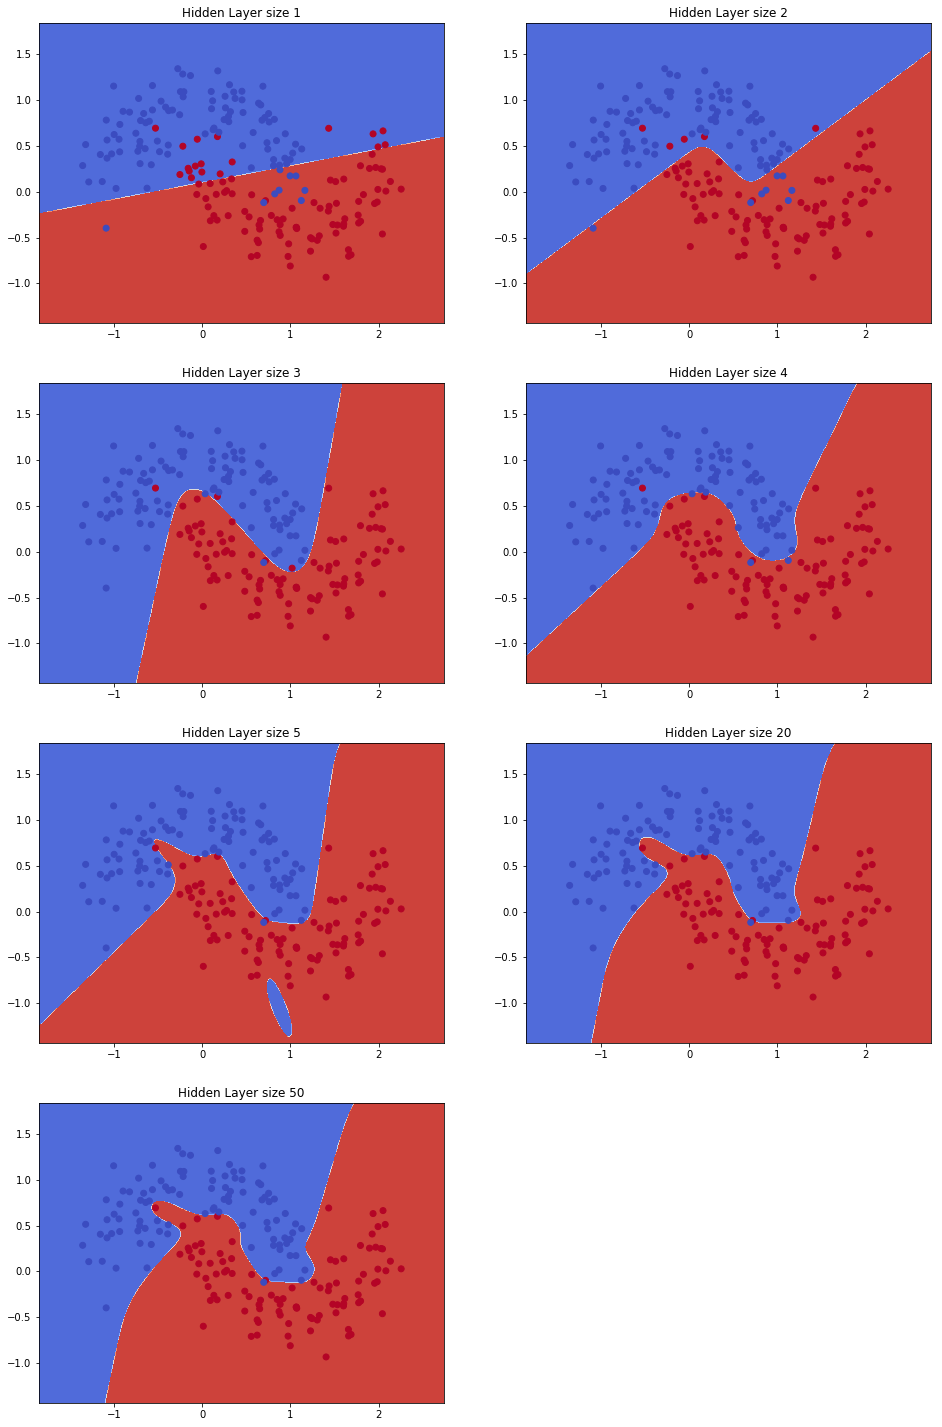

In [32]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(np.array([nn_hdim]))
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

instantiating random weights...
instantiating random weights...
Loss after iteration  1000 :  0.0602652576755
Loss after iteration  2000 :  0.0362965742809
Loss after iteration  3000 :  0.0250863991826
Loss after iteration  4000 :  0.0276613415726
Loss after iteration  5000 :  0.0271118094463
Loss after iteration  6000 :  0.019906540415
Loss after iteration  7000 :  0.020795661066
Loss after iteration  8000 :  0.0201242759629
Loss after iteration  9000 :  0.020356981387
Loss after iteration  10000 :  0.0192816663963
Loss after iteration  11000 :  0.0795031323568
Loss after iteration  12000 :  0.0210677364355
Loss after iteration  13000 :  0.0200271830117
Loss after iteration  14000 :  0.0199207596394
Loss after iteration  15000 :  0.185409097462
Loss after iteration  16000 :  0.0246489567203
Loss after iteration  17000 :  0.033716675814
Loss after iteration  18000 :  0.0213831477726
Loss after iteration  19000 :  0.0208838888309
Loss after iteration  20000 :  0.0205148606849
predicting

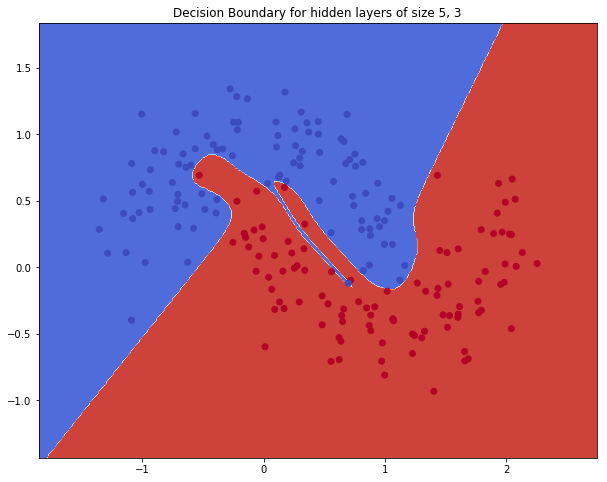

In [33]:
model = build_model(np.array([5,3]), print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of size 5, 3")

instantiating random weights...
instantiating random weights...
instantiating random weights...
Loss after iteration  1000 :  0.0574989326232
Loss after iteration  2000 :  0.0499901471937
Loss after iteration  3000 :  0.0489898591239
Loss after iteration  4000 :  0.0593786467862
Loss after iteration  5000 :  0.0599776660057
Loss after iteration  6000 :  0.0460504532427
Loss after iteration  7000 :  0.0665341430877
Loss after iteration  8000 :  0.0492512789761
Loss after iteration  9000 :  0.0441275048956
Loss after iteration  10000 :  0.0434594687791
Loss after iteration  11000 :  0.0512754786989
Loss after iteration  12000 :  0.044777556077
Loss after iteration  13000 :  0.0433902235259
Loss after iteration  14000 :  0.231505393533
Loss after iteration  15000 :  0.0506783303473
Loss after iteration  16000 :  0.0658837471127
Loss after iteration  17000 :  0.0939375414346
Loss after iteration  18000 :  0.0590417501483
Loss after iteration  19000 :  0.057208860281
Loss after iteration  2

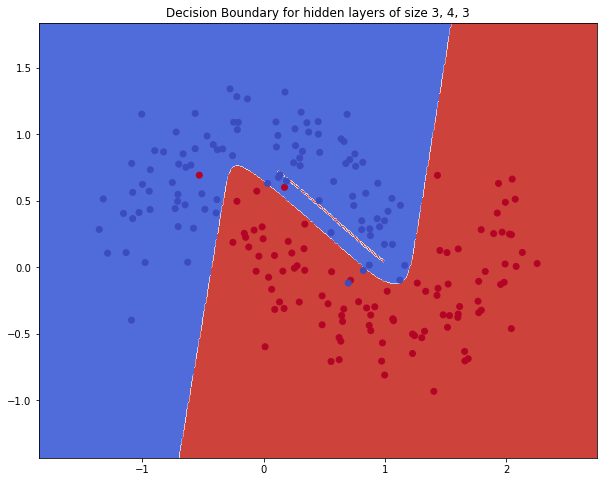

In [34]:
model = build_model(np.array([3,4,3]), print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of size 3, 4, 3")

instantiating random weights...
instantiating random weights...
instantiating random weights...
Loss after iteration  1000 :  0.0474729997962
Loss after iteration  2000 :  0.0359737237724
Loss after iteration  3000 :  0.0174669321176
Loss after iteration  4000 :  0.0157411178762
Loss after iteration  5000 :  0.0152111559455
Loss after iteration  6000 :  0.0148550249437
Loss after iteration  7000 :  0.0550647182693
Loss after iteration  8000 :  0.0576872938921
Loss after iteration  9000 :  0.0161357695017
Loss after iteration  10000 :  0.055976363267
Loss after iteration  11000 :  0.0322140248854
Loss after iteration  12000 :  0.0307627729317
Loss after iteration  13000 :  0.0901631194599
Loss after iteration  14000 :  0.088388777265
Loss after iteration  15000 :  0.132734830269
Loss after iteration  16000 :  0.0390001751431
Loss after iteration  17000 :  0.0345292862128
Loss after iteration  18000 :  0.0339596165686
Loss after iteration  19000 :  0.0335750434171
Loss after iteration  2

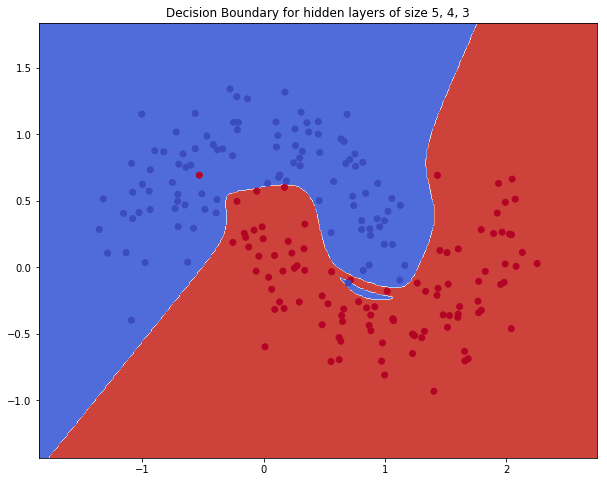

In [35]:
model = build_model(np.array([5,4,3]), print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of size 5, 4, 3")

instantiating random weights...
instantiating random weights...
instantiating random weights...
instantiating random weights...
Loss after iteration  1000 :  0.0727443818416
Loss after iteration  2000 :  0.0670412857048
Loss after iteration  3000 :  0.0707482923365
Loss after iteration  4000 :  0.0955393970399
Loss after iteration  5000 :  0.0678090724439
Loss after iteration  6000 :  0.0951847848113
Loss after iteration  7000 :  0.0548835152465
Loss after iteration  8000 :  0.0964040414505
Loss after iteration  9000 :  0.0464270333127
Loss after iteration  10000 :  0.030144780159
Loss after iteration  11000 :  0.0848776995894
Loss after iteration  12000 :  0.078200931363
Loss after iteration  13000 :  0.0825223655116
Loss after iteration  14000 :  0.0686814118176
Loss after iteration  15000 :  0.0816121344879
Loss after iteration  16000 :  0.0526679956774
Loss after iteration  17000 :  0.0496368130785
Loss after iteration  18000 :  0.0486848474907
Loss after iteration  19000 :  0.0807

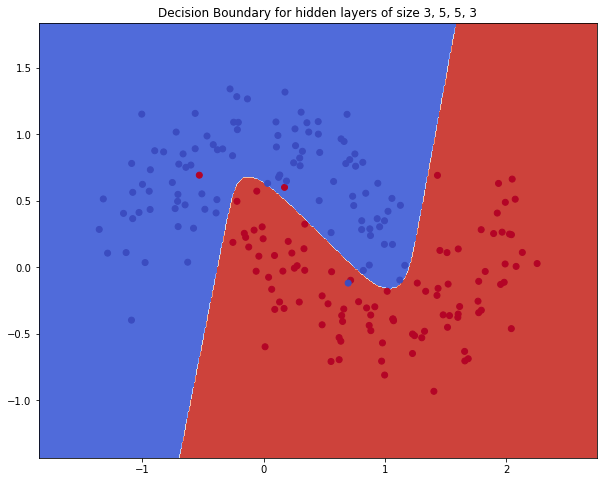

In [36]:
model = build_model(np.array([3,5,5,3]), print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of size 3, 5, 5, 3")

instantiating random weights...
instantiating random weights...
instantiating random weights...
instantiating random weights...
instantiating random weights...
Loss after iteration  1000 :  0.044567249887
Loss after iteration  2000 :  0.0275496540955
Loss after iteration  3000 :  0.0425765589391
Loss after iteration  4000 :  0.117114133847
Loss after iteration  5000 :  0.148464014734
Loss after iteration  6000 :  0.0451676923494
Loss after iteration  7000 :  0.0380245349998
Loss after iteration  8000 :  0.0339035807195
Loss after iteration  9000 :  0.19014362121
Loss after iteration  10000 :  0.154680271466
Loss after iteration  11000 :  0.0963979534365
Loss after iteration  12000 :  0.114325766379
Loss after iteration  13000 :  0.0441929128769
Loss after iteration  14000 :  0.0427136998518
Loss after iteration  15000 :  0.0418779158006
Loss after iteration  16000 :  0.0401884270741
Loss after iteration  17000 :  0.0342650441973
Loss after iteration  18000 :  0.0332227036935
Loss after

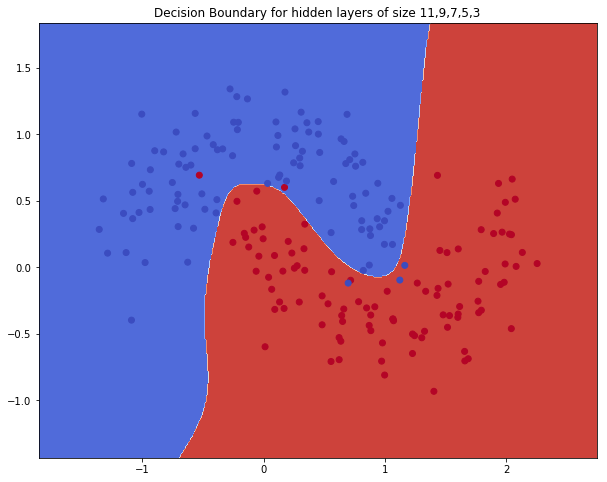

In [37]:
model = build_model(np.array([11,9,7,5,3]), print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of size 11,9,7,5,3")

instantiating random weights...
Loss after iteration  1000 :  0.0669639904047
Loss after iteration  2000 :  0.0600837302885
Loss after iteration  3000 :  0.0572245937362
Loss after iteration  4000 :  0.0511631727783
Loss after iteration  5000 :  0.0453997824378
Loss after iteration  6000 :  0.0422597148591
Loss after iteration  7000 :  0.0402936934955
Loss after iteration  8000 :  0.0388304034027
Loss after iteration  9000 :  0.0375421482156
Loss after iteration  10000 :  0.0359298157788
Loss after iteration  11000 :  0.0355242862371
Loss after iteration  12000 :  0.0349877147309
Loss after iteration  13000 :  0.0344383969467
Loss after iteration  14000 :  0.0340133275582
Loss after iteration  15000 :  0.0333417758001
Loss after iteration  16000 :  0.0330602270597
Loss after iteration  17000 :  0.032877847018
Loss after iteration  18000 :  0.0327362825097
Loss after iteration  19000 :  0.0326198211592
Loss after iteration  20000 :  0.0325191937297
predicting...


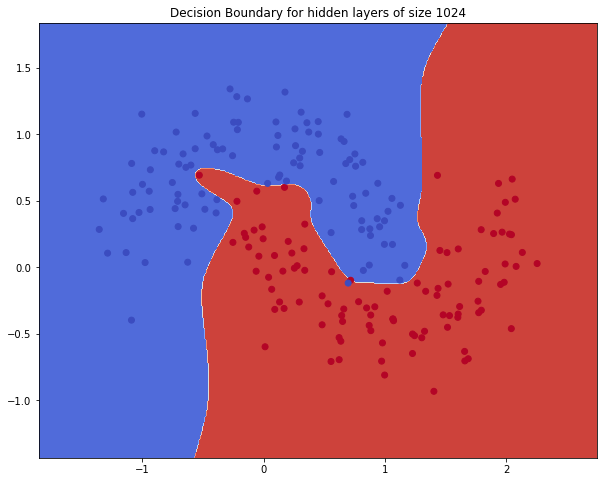

In [38]:
model = build_model(np.array([1024]), print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layers of size 1024")